In [13]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os
os.chdir('..')

In [3]:
train = pd.read_csv('data/titanic/train.csv')
test = pd.read_csv('data/titanic/test.csv')

In [7]:
drop_cols = ['PassengerId', 'Cabin', 'Ticket', 'Name', 'Survived']
keep_cols = [c for c in train.columns if c not in drop_cols]
cat_cols = ['Sex', 'Embarked']
cont_cols = ['Age', 'Fare']

In [12]:
from sklearn.preprocessing import LabelEncoder

In [13]:
def process_data_train(X, keep_cols, cat_cols, cont_cols):
    X = X[keep_cols].copy()
    lencoders = {}
    for c in cat_cols:
        X[c] = X[c].astype(str)
        lencoders[c] = LabelEncoder()
        X[c] = lencoders[c].fit_transform(X[c])
    means = {}
    for c in cont_cols:
        X[f'{c}Missing'] = X[c].isnull()
        means[c] = X[c].mean()
        X[c] = X[c].fillna(means[c])
    return X, lencoders, means

In [14]:
def process_data_test(X, keep_cols, lencoders, means):
    X = X[keep_cols].copy()
    for c in lencoders:
        X[c] = X[c].astype(str)
        X[c] = lencoders[c].transform(X[c])
    for c in means:
        X[f'{c}Missing'] = X[c].isnull()
        X[c] = X[c].fillna(means[c])
    return X

In [15]:
X, lencoders, means = process_data_train(train, keep_cols, cat_cols, cont_cols)

In [16]:
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,AgeMissing,FareMissing
0,3,1,22.0,1,0,7.2500,2,False,False
1,1,0,38.0,1,0,71.2833,0,False,False
2,3,0,26.0,0,0,7.9250,2,False,False
3,1,0,35.0,1,0,53.1000,2,False,False
4,3,1,35.0,0,0,8.0500,2,False,False


In [20]:
X_test = process_data_test(test, keep_cols, lencoders, means)

In [21]:
X_test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,AgeMissing,FareMissing
0,3,1,34.5,0,0,7.8292,1,False,False
1,3,0,47.0,1,0,7.0000,2,False,False
2,2,1,62.0,0,0,9.6875,1,False,False
3,3,1,27.0,0,0,8.6625,2,False,False
4,3,0,22.0,1,1,12.2875,2,False,False


# Train - validation split

In [22]:
from sklearn.model_selection import train_test_split

In [73]:
trn, val = train_test_split(train, test_size=0.2)

In [74]:
X_trn, lencoders, means = process_data_train(trn, keep_cols, 
                                             cat_cols, cont_cols)
X_val = process_data_test(val, keep_cols, lencoders, means)

In [89]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier()

In [90]:
tree.fit(X_trn, trn.Survived)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [91]:
y_pred_train = tree.predict(X_trn)
y_pred_valid = tree.predict(X_val)

In [92]:
from sklearn.metrics import accuracy_score
train_acc = accuracy_score(trn.Survived, y_pred_train)
valid_acc = accuracy_score(val.Survived, y_pred_valid)
print(f'Train Acc: {train_acc:.2%} | Valid Acc: {valid_acc:.2%}')

Train Acc: 98.60% | Valid Acc: 74.86%


# Cross validation

In [79]:
from sklearn.model_selection import KFold
kfolds = KFold(n_splits=5)

In [130]:
train_accs = []
valid_accs = []
for idx, (trn_idx, val_idx) in enumerate(kfolds.split(train)):
    trn, val = train.iloc[trn_idx], train.iloc[val_idx]
    X_trn, lencoders, means = process_data_train(trn, keep_cols, 
                                             cat_cols, cont_cols)
    X_val = process_data_test(val, keep_cols, lencoders, means)
    tree = DecisionTreeClassifier()
    tree.fit(X_trn, trn.Survived)
    y_pred_train = tree.predict(X_trn)
    y_pred_valid = tree.predict(X_val)
    train_acc = accuracy_score(trn.Survived, y_pred_train)
    valid_acc = accuracy_score(val.Survived, y_pred_valid)
    train_accs.append(train_acc)
    valid_accs.append(valid_acc)
    print(f'Fold: {idx+1} | Train Acc: {train_acc:.2%} | Valid Acc: {valid_acc:.2%}')
print(f'Mean train acc: {np.mean(train_accs):.2%} | '
      f'Mean valid acc: {np.mean(valid_accs):.2%}')

Fold: 1 | Train Acc: 98.31% | Valid Acc: 72.63%
Fold: 2 | Train Acc: 98.88% | Valid Acc: 80.34%
Fold: 3 | Train Acc: 98.32% | Valid Acc: 80.34%
Fold: 4 | Train Acc: 98.60% | Valid Acc: 75.28%
Fold: 5 | Train Acc: 98.18% | Valid Acc: 78.65%
Mean train acc: 98.46% | Mean valid acc: 77.45%


In [174]:
train_accs = []
valid_accs = []
models = []
for idx, (trn_idx, val_idx) in enumerate(kfolds.split(train)):
    trn, val = train.iloc[trn_idx], train.iloc[val_idx]
    X_trn, lencoders, means = process_data_train(trn, keep_cols, 
                                             cat_cols, cont_cols)
    X_val = process_data_test(val, keep_cols, lencoders, means)
    tree = DecisionTreeClassifier(max_depth=10, min_samples_split=10)
    tree.fit(X_trn, trn.Survived)
    models.append(tree)
    y_pred_train = tree.predict(X_trn)
    y_pred_valid = tree.predict(X_val)
    train_acc = accuracy_score(trn.Survived, y_pred_train)
    valid_acc = accuracy_score(val.Survived, y_pred_valid)
    train_accs.append(train_acc)
    valid_accs.append(valid_acc)
    print(f'Fold: {idx+1} | Train Acc: {train_acc:.2%} | Valid Acc: {valid_acc:.2%}')
print(f'Mean train acc: {np.mean(train_accs):.2%} | '
      f'Mean valid acc: {np.mean(valid_accs):.2%}')

Fold: 1 | Train Acc: 89.75% | Valid Acc: 79.89%
Fold: 2 | Train Acc: 89.90% | Valid Acc: 81.46%
Fold: 3 | Train Acc: 88.36% | Valid Acc: 83.15%
Fold: 4 | Train Acc: 89.76% | Valid Acc: 76.97%
Fold: 5 | Train Acc: 89.48% | Valid Acc: 84.27%
Mean train acc: 89.45% | Mean valid acc: 81.15%


## Feature importance

In [177]:
feat_imp = pd.DataFrame()
feat_imp['feature'] = X_trn.columns
feat_imp['importance'] = models[4].feature_importances_

In [178]:
feat_imp

,feature,importance
0,Pclass,0.135646
1,Sex,0.413017
2,Age,0.175040
3,SibSp,0.049041
4,Parch,0.005794
5,Fare,0.201593
6,Embarked,0.003940
7,AgeMissing,0.015929
8,FareMissing,0.000000


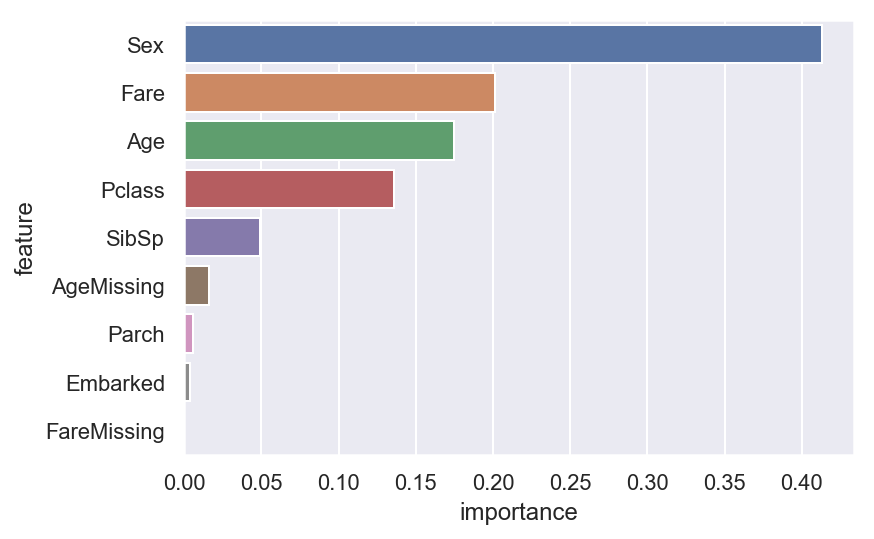

In [181]:
sns.barplot(y='feature', x='importance', 
            data=feat_imp.sort_values('importance', ascending=False));

# Improvements

In [102]:
drop_cols = ['PassengerId', 'Cabin', 'Ticket', 'Name', 'Survived']
keep_cols = [c for c in train.columns if c not in drop_cols]
cat_cols = ['Sex', 'Embarked']
cont_cols = ['Age', 'Fare']

In [144]:
def missing_values(X, cont_cols, medians=None):
    if not medians: medians = {}
    for c in cont_cols:
        if X[c].isnull().sum() > 10: X[f'{c}Missing'] = X[c].isnull() 
        X[c].fillna(medians.get(c, X[c].median()), inplace=True)
    return X, medians

In [145]:
def feature_engineering(X, dataset, cont_cols, quantiles=None):
    X['FamilySize'] = X.SibSp + X.Parch + 1
#     X['IsAlone'] = X.FamilySize == 1
    X['Title'] = dataset.Name.str.split(', ', expand=True)[1] \
                             .str.split('.', expand=True)[0]
#     if not quantiles: quantiles = {}
#     for c in cont_cols:
#         X[f'{c}Bin'] = pd.cut(X[c], quantiles.get(c, np.quantile(X[c], 
#                               [.2, .4, .6, .8])), duplicates='drop')  
    return X, quantiles

In [146]:
def label_encode(X, cat_cols, titles=None, X_train=None):
    if not titles: 
        titles = X.Title.value_counts()
        titles = titles[X.Title.value_counts() > 10].index.tolist()
    X['Title'] = X.Title.apply(lambda x: x if x in titles else 'Misc')
    for c in cat_cols:
        X[c] = pd.Categorical(X[c], categories=X_train[c].cat.categories, 
                              ordered=True) if X_train is not None else \
               X[c].astype('category').cat.as_ordered()
    return X, titles        

In [147]:
def process_data(dataset, keep_cols, cat_cols, cont_cols, 
                 medians=None, quantiles=None, titles=None,
                 X_train=None):
    X = dataset[keep_cols].copy()
    X, medians = missing_values(X, cont_cols, medians)
    X, quantiles = feature_engineering(X, dataset, cont_cols, quantiles)
#     cat_cols += ['Title'] # + [f'{c}Bin' for c in cont_cols]
    X, titles = label_encode(X, cat_cols + ['Title'] , titles, X_train)
    return X, medians, quantiles, titles

In [148]:
from sklearn.model_selection import train_test_split
trn, val = train_test_split(train, test_size=0.2, random_state=42)

In [149]:
X_trn, medians, quantiles, titles = process_data(trn, keep_cols, cat_cols, cont_cols)
X_val, _,_,_ = process_data(val, keep_cols, cat_cols, cont_cols, medians, quantiles,
                            titles, X_trn)

In [150]:
for c in X_trn.columns:
    if X_trn[c].dtype.name == 'category':
        X_trn[c] = X_trn[c].cat.codes
        X_val[c] = X_val[c].cat.codes

In [151]:
from lightgbm import LGBMClassifier
model = LGBMClassifier()
model.fit(X_trn, trn.Survived)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [152]:
y_pred_train = model.predict(X_trn)
y_pred_valid = model.predict(X_val)

from sklearn.metrics import accuracy_score
train_acc = accuracy_score(trn.Survived, y_pred_train)
valid_acc = accuracy_score(val.Survived, y_pred_valid)
print(f'Train Acc: {train_acc:.2%} | Valid Acc: {valid_acc:.2%}')

Train Acc: 94.94% | Valid Acc: 83.24%


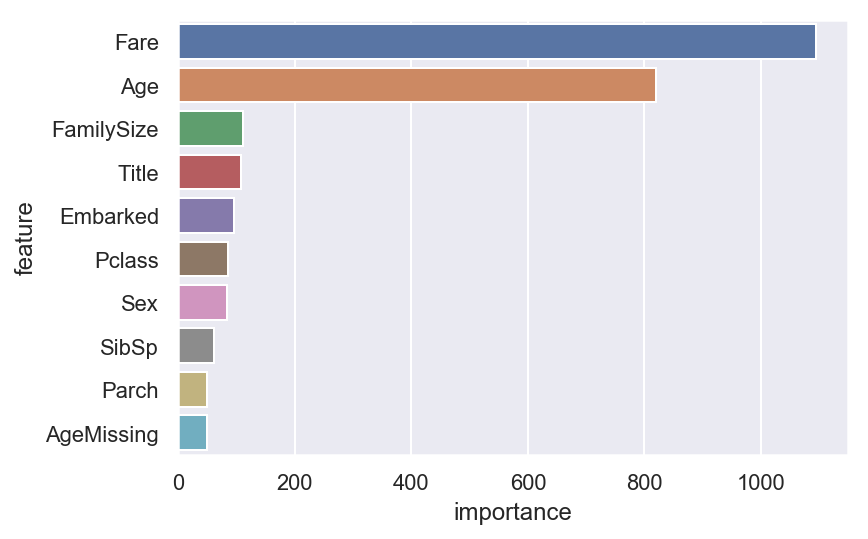

In [153]:
feat_imp = pd.DataFrame()
feat_imp['feature'] = X_trn.columns
feat_imp['importance'] = model.feature_importances_
sns.barplot(y='feature', x='importance', 
            data=feat_imp.sort_values('importance', ascending=False));

## Cross validation

In [154]:
from sklearn.model_selection import KFold
kfolds = KFold(n_splits=5)

In [155]:
def cross_validate(model, train):
    train_accs = []
    valid_accs = []
    models = []
    for idx, (trn_idx, val_idx) in enumerate(kfolds.split(train)):
        trn, val = train.iloc[trn_idx], train.iloc[val_idx]
        
        X_trn, medians, quantiles, titles = process_data(trn, keep_cols, cat_cols, cont_cols)
        X_val, _,_,_ = process_data(val, keep_cols, cat_cols, cont_cols, medians, quantiles,
                                    titles, X_trn)
        for c in X_trn.columns:
            if X_trn[c].dtype.name == 'category':
                X_trn[c] = X_trn[c].cat.codes
                X_val[c] = X_val[c].cat.codes
        
        model.fit(X_trn, trn.Survived)
        models.append(model)
        y_pred_train = model.predict(X_trn)
        y_pred_valid = model.predict(X_val)
        train_acc = accuracy_score(trn.Survived, y_pred_train)
        valid_acc = accuracy_score(val.Survived, y_pred_valid)
        train_accs.append(train_acc)
        valid_accs.append(valid_acc)
        print(f'Fold: {idx+1} | Train Acc: {train_acc:.2%} | Valid Acc: {valid_acc:.2%}')
    print(f'Mean train acc: {np.mean(train_accs):.2%} | '
          f'Mean valid acc: {np.mean(valid_accs):.2%}')
    return train_accs, valid_accs, models

In [156]:
train_accs, valid_accs, models = cross_validate(LGBMClassifier(), train)

Fold: 1 | Train Acc: 95.08% | Valid Acc: 80.45%
Fold: 2 | Train Acc: 96.07% | Valid Acc: 82.02%
Fold: 3 | Train Acc: 94.81% | Valid Acc: 87.08%
Fold: 4 | Train Acc: 96.21% | Valid Acc: 79.78%
Fold: 5 | Train Acc: 93.83% | Valid Acc: 87.64%
Mean train acc: 95.20% | Mean valid acc: 83.39%


In [157]:
from catboost import CatBoostClassifier

In [158]:
X_trn.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,AgeMissing,FamilySize,Title
331,1,1,45.5,0,0,28.5000,2,False,1,3
733,2,1,23.0,0,0,13.0000,2,False,1,3
382,3,1,32.0,0,0,7.9250,2,False,1,3
704,3,1,26.0,1,0,7.8542,2,False,2,3
813,3,0,6.0,4,2,31.2750,2,False,7,2


In [161]:
cat_columns = ['Pclass', 'Sex', 'Embarked', 'AgeMissing', 'Title']
cat_indices = [i for i, c in enumerate(X_trn.columns) if c in cat_columns]

In [162]:
catboost = CatBoostClassifier(cat_features=cat_indices, verbose=False)

In [163]:
train_accs, valid_accs, models = cross_validate(catboost, train)

Fold: 1 | Train Acc: 87.50% | Valid Acc: 78.77%
Fold: 2 | Train Acc: 88.92% | Valid Acc: 82.02%
Fold: 3 | Train Acc: 86.68% | Valid Acc: 83.71%
Fold: 4 | Train Acc: 86.82% | Valid Acc: 78.09%
Fold: 5 | Train Acc: 86.68% | Valid Acc: 84.83%
Mean train acc: 87.32% | Mean valid acc: 81.48%


## Submission Catboost

In [180]:
def process_datasets(train, test, encode=True):
    X_trn, medians, quantiles, titles = process_data(train, keep_cols, cat_cols, cont_cols)
    X_tst, _,_,_ = process_data(test, keep_cols, cat_cols, cont_cols, medians, quantiles,
                                titles, X_trn)
    for c in X_trn.columns:
        if encode and X_trn[c].dtype.name == 'category':
            X_trn[c] = X_trn[c].cat.codes
            X_tst[c] = X_tst[c].cat.codes
    return X_trn, X_tst

In [45]:
X_trn, X_tst = process_datasets(train, test)

In [46]:
catboost = CatBoostClassifier(cat_features=cat_indices, verbose=False)
catboost.fit(X_trn, train.Survived)

In [48]:
y_test = catboost.predict(X_tst)

In [57]:
submission = pd.read_csv('data/titanic/gender_submission.csv')
submission['Survived'] = y_test.astype(int)
submission.to_csv('catboost.csv', index=False)

In [58]:
submission.Survived.value_counts()

0    279
1    139
Name: Survived, dtype: int64

## Submission LigthGBM

In [164]:
X_trn, X_tst = process_datasets(train, test)

In [165]:
model = LGBMClassifier()
model = model.fit(X_trn, train.Survived)

In [167]:
submission = pd.read_csv('data/titanic/gender_submission.csv')
submission['Survived'] = model.predict(X_tst).astype(int)
submission.to_csv('lgbm.csv', index=False)

# Feature Correlation

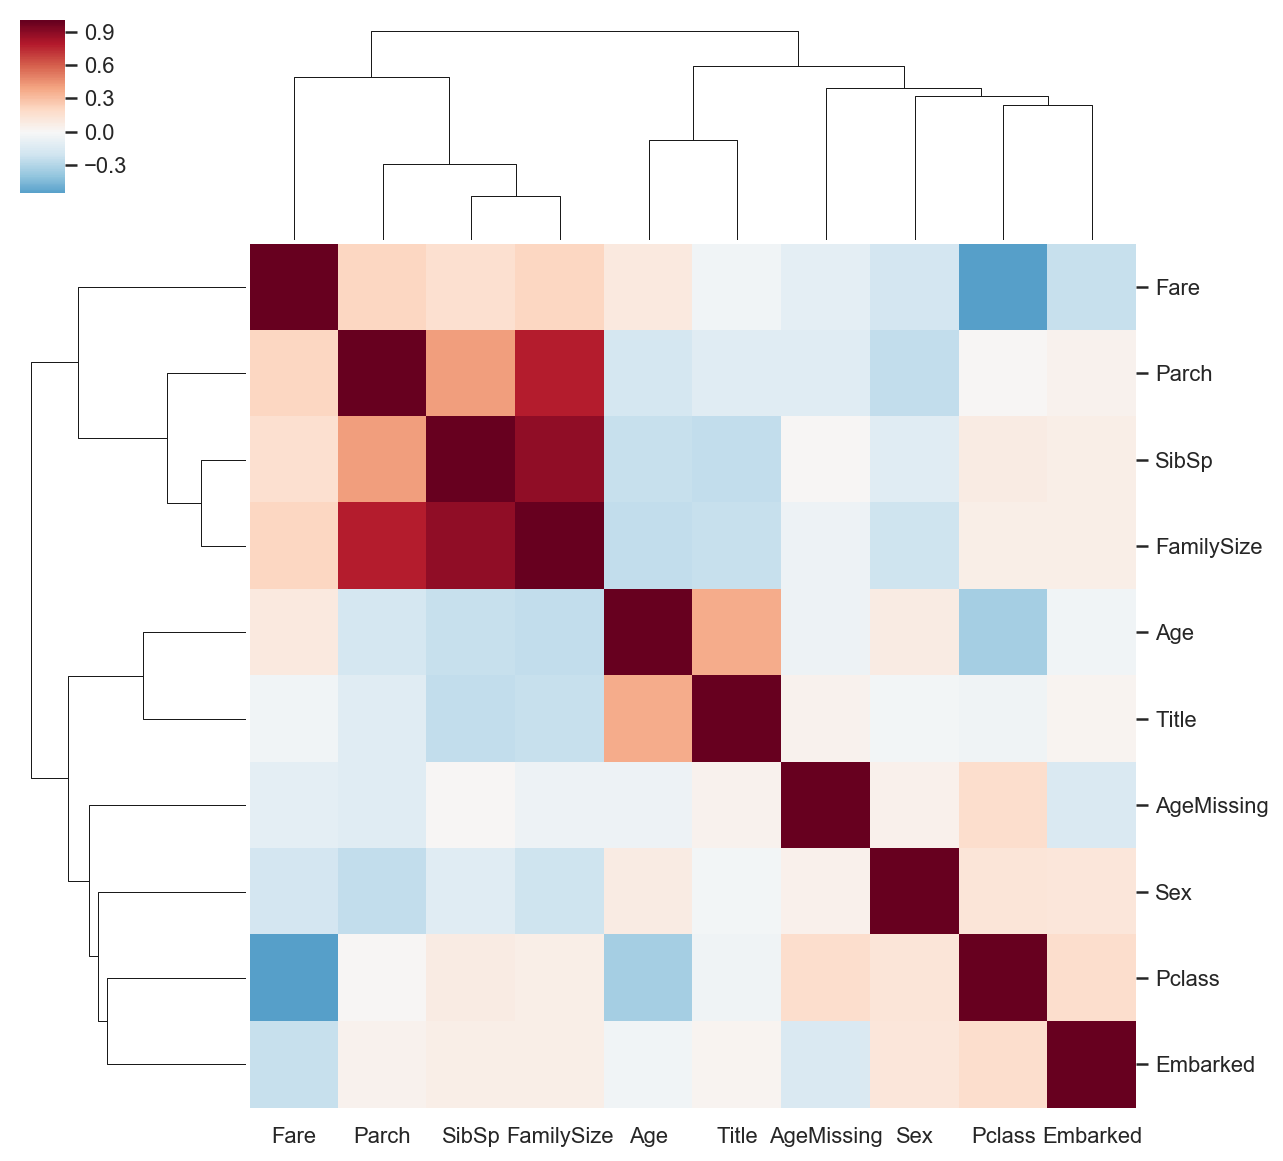

In [173]:
sns.clustermap(X_trn.corr(), center=0, cmap='RdBu_r')

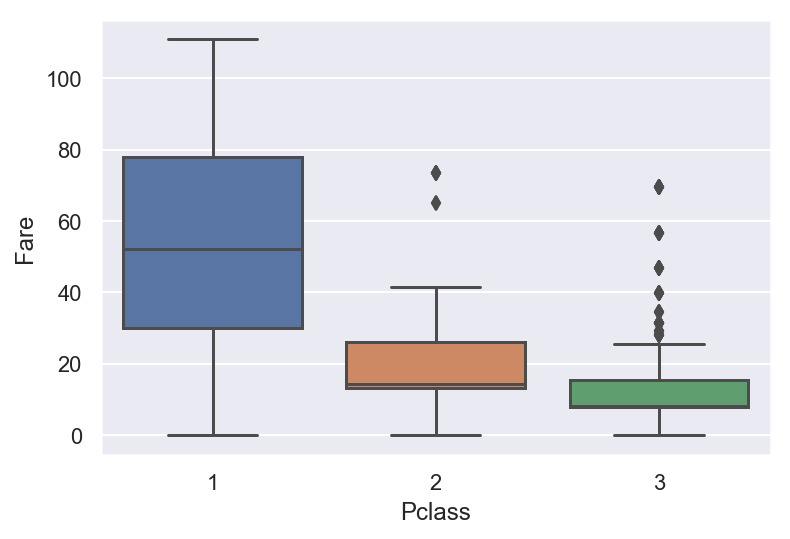

In [177]:
sns.boxplot(y='Fare', x='Pclass', data=train[train.Fare < train.Fare.quantile(0.95)]);

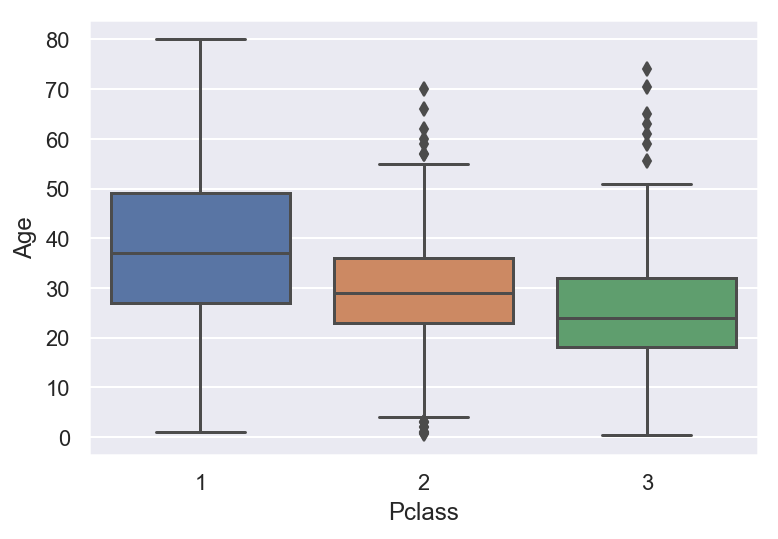

In [179]:
sns.boxplot(y='Age', x='Pclass', data=train);

In [181]:
X_trn, X_tst = process_datasets(train, test, encode=False)

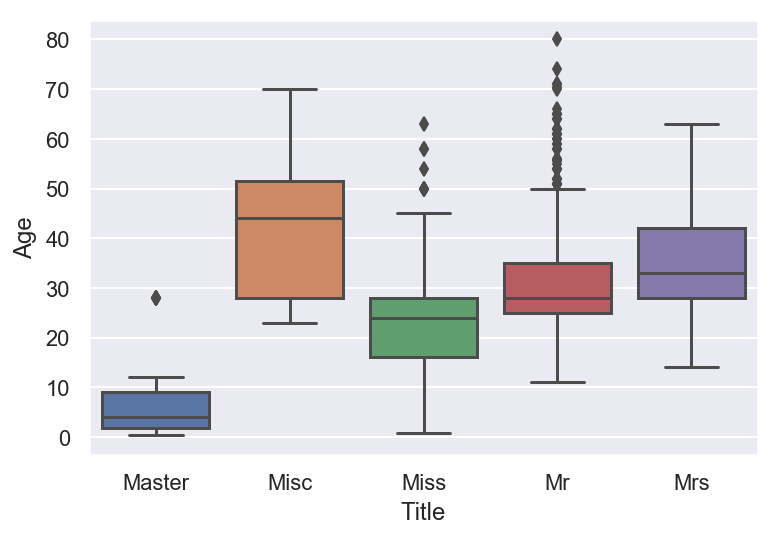

In [183]:
sns.boxplot(y='Age', x='Title', data=X_trn);

## Permutation Importance

In [185]:
from sklearn.model_selection import train_test_split
trn, val = train_test_split(train, test_size=0.2, random_state=42)

In [186]:
X_trn, X_val = process_datasets(trn, val)

CPU times: user 674 ms, sys: 174 ms, total: 848 ms
Wall time: 280 ms


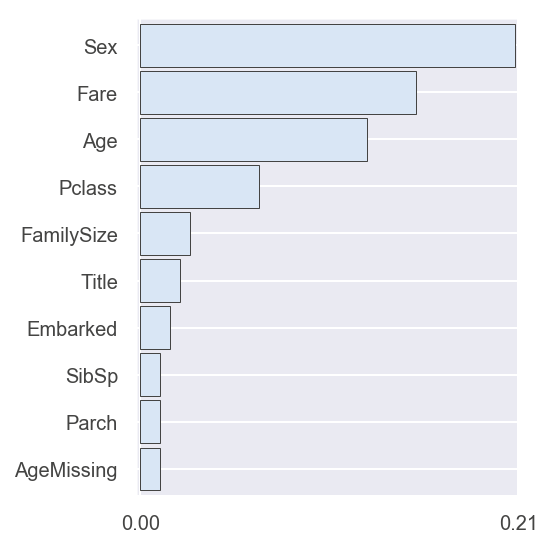

In [194]:
%%time
from rfpimp import importances, plot_importances
imp = importances(model, X_val, val.Survived)
plot_importances(imp, width=4, minheight=4);

CPU times: user 3.09 s, sys: 220 ms, total: 3.31 s
Wall time: 936 ms


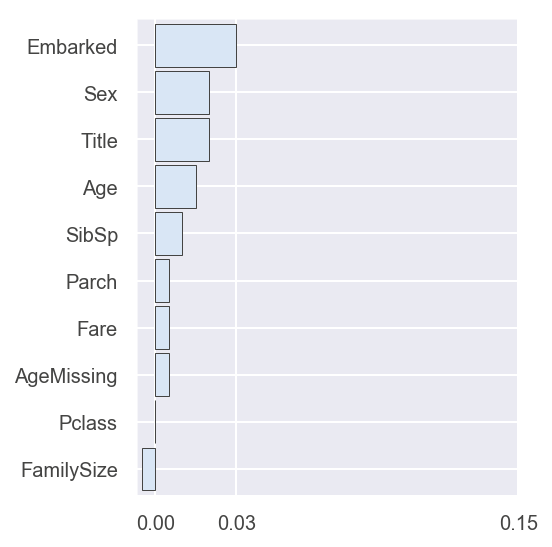

In [196]:
%%time
from rfpimp import dropcol_importances
imp = dropcol_importances(model, X_trn, trn.Survived, X_val, val.Survived)
plot_importances(imp, width=4, minheight=4);

## Confusion matrix

In [275]:
from sklearn.metrics import confusion_matrix, classification_report

In [270]:
model = LGBMClassifier()
model = model.fit(X_trn, trn.Survived)

In [271]:
val_pred = model.predict(X_val)

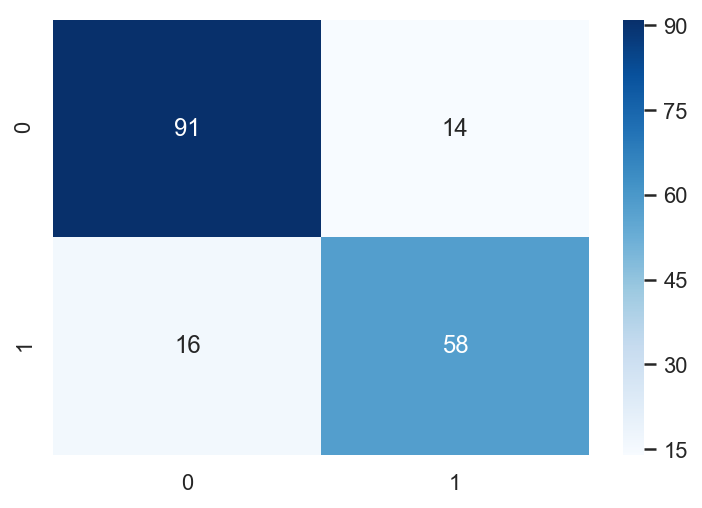

In [293]:
sns.heatmap(confusion_matrix(val.Survived, val_pred), cmap='Blues', annot=True);

In [277]:
print(classification_report(val.Survived, val_pred))

              precision    recall  f1-score   support

           0       0.85      0.87      0.86       105
           1       0.81      0.78      0.79        74

   micro avg       0.83      0.83      0.83       179
   macro avg       0.83      0.83      0.83       179
weighted avg       0.83      0.83      0.83       179



In [281]:
results = pd.DataFrame()
results['Survived'] = val.Survived
results['PredSurvived'] = model.predict(X_val)
results['ProbSurvived'] = model.predict_proba(X_val)[:,1]

In [282]:
results.head()

,Survived,PredSurvived,ProbSurvived
709,1,0,0.076240
439,0,0,0.162975
840,0,0,0.311377
720,1,1,0.995031
39,1,1,0.654319


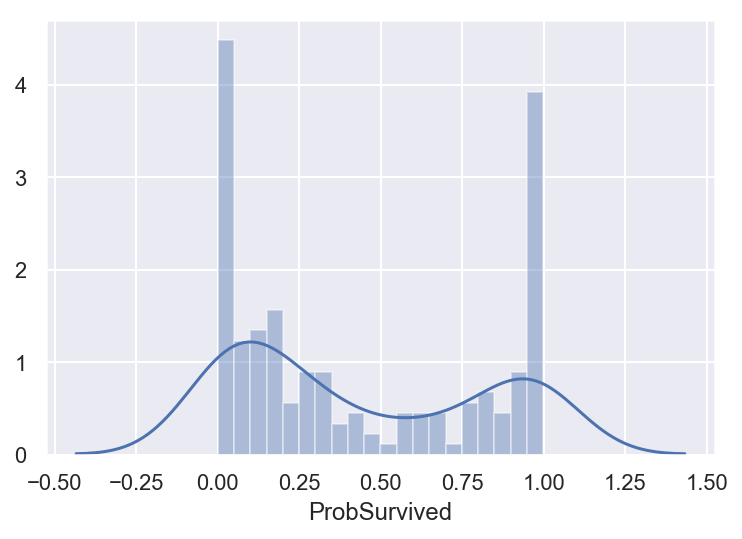

In [287]:
sns.distplot(results.ProbSurvived, bins=20);

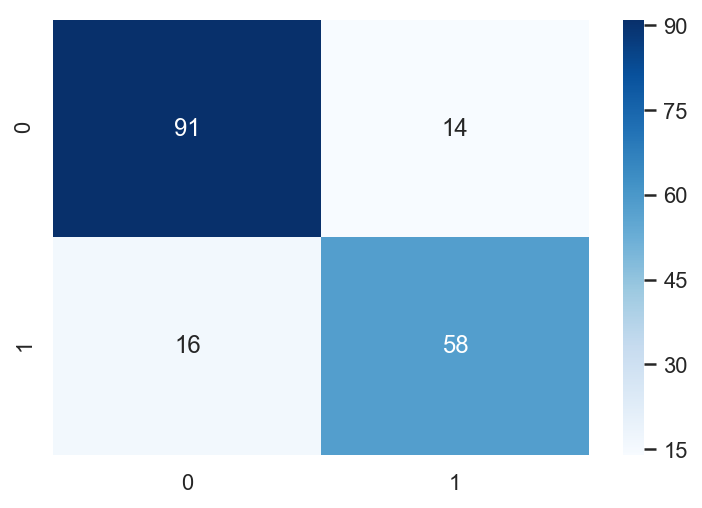

In [294]:
sns.heatmap(confusion_matrix(val.Survived, val_pred), cmap='Blues', annot=True);

In [295]:
print(classification_report(val.Survived, val_pred))

              precision    recall  f1-score   support

           0       0.85      0.87      0.86       105
           1       0.81      0.78      0.79        74

   micro avg       0.83      0.83      0.83       179
   macro avg       0.83      0.83      0.83       179
weighted avg       0.83      0.83      0.83       179



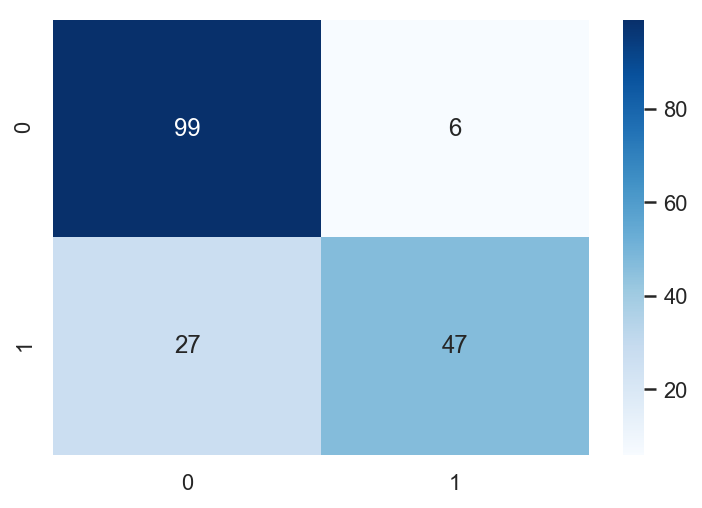

In [303]:
results['NewPredSurvived'] = results.ProbSurvived > 0.8
sns.heatmap(confusion_matrix(val.Survived, results.NewPredSurvived), cmap='Blues', annot=True);

In [304]:
print(classification_report(val.Survived, results.NewPredSurvived))

              precision    recall  f1-score   support

           0       0.79      0.94      0.86       105
           1       0.89      0.64      0.74        74

   micro avg       0.82      0.82      0.82       179
   macro avg       0.84      0.79      0.80       179
weighted avg       0.83      0.82      0.81       179



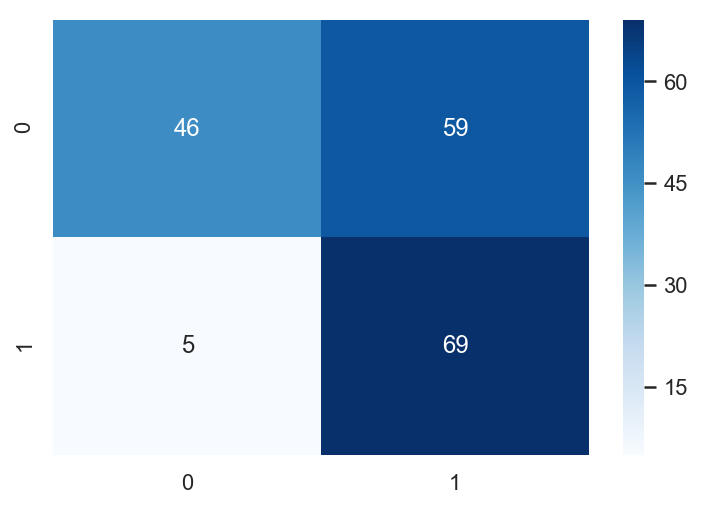

In [309]:
results['NewPredSurvived'] = results.ProbSurvived > 0.1
sns.heatmap(confusion_matrix(val.Survived, results.NewPredSurvived), cmap='Blues', annot=True);

In [310]:
print(classification_report(val.Survived, results.NewPredSurvived))

              precision    recall  f1-score   support

           0       0.90      0.44      0.59       105
           1       0.54      0.93      0.68        74

   micro avg       0.64      0.64      0.64       179
   macro avg       0.72      0.69      0.64       179
weighted avg       0.75      0.64      0.63       179



## ROC Curve

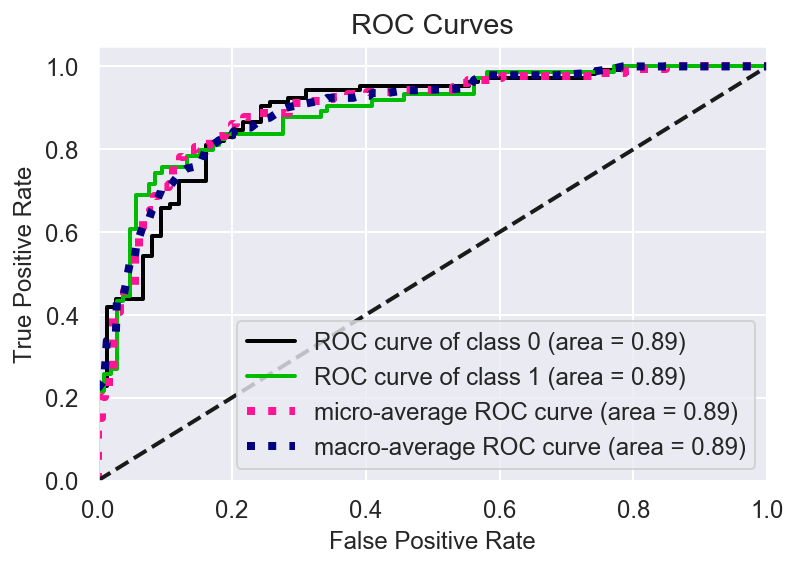

In [321]:
import scikitplot as skplt
skplt.metrics.plot_roc_curve(results.Survived, model.predict_proba(X_val));

In [323]:
from sklearn.metrics import roc_auc_score
rocauc = roc_auc_score(results.Survived, results.ProbSurvived)
print(f'Validation ROC-AUC: {rocauc:.2%}')

Validation ROC-AUC: 89.01%


## Partial dependence plots

In [199]:
from pdpbox import pdp, info_plots

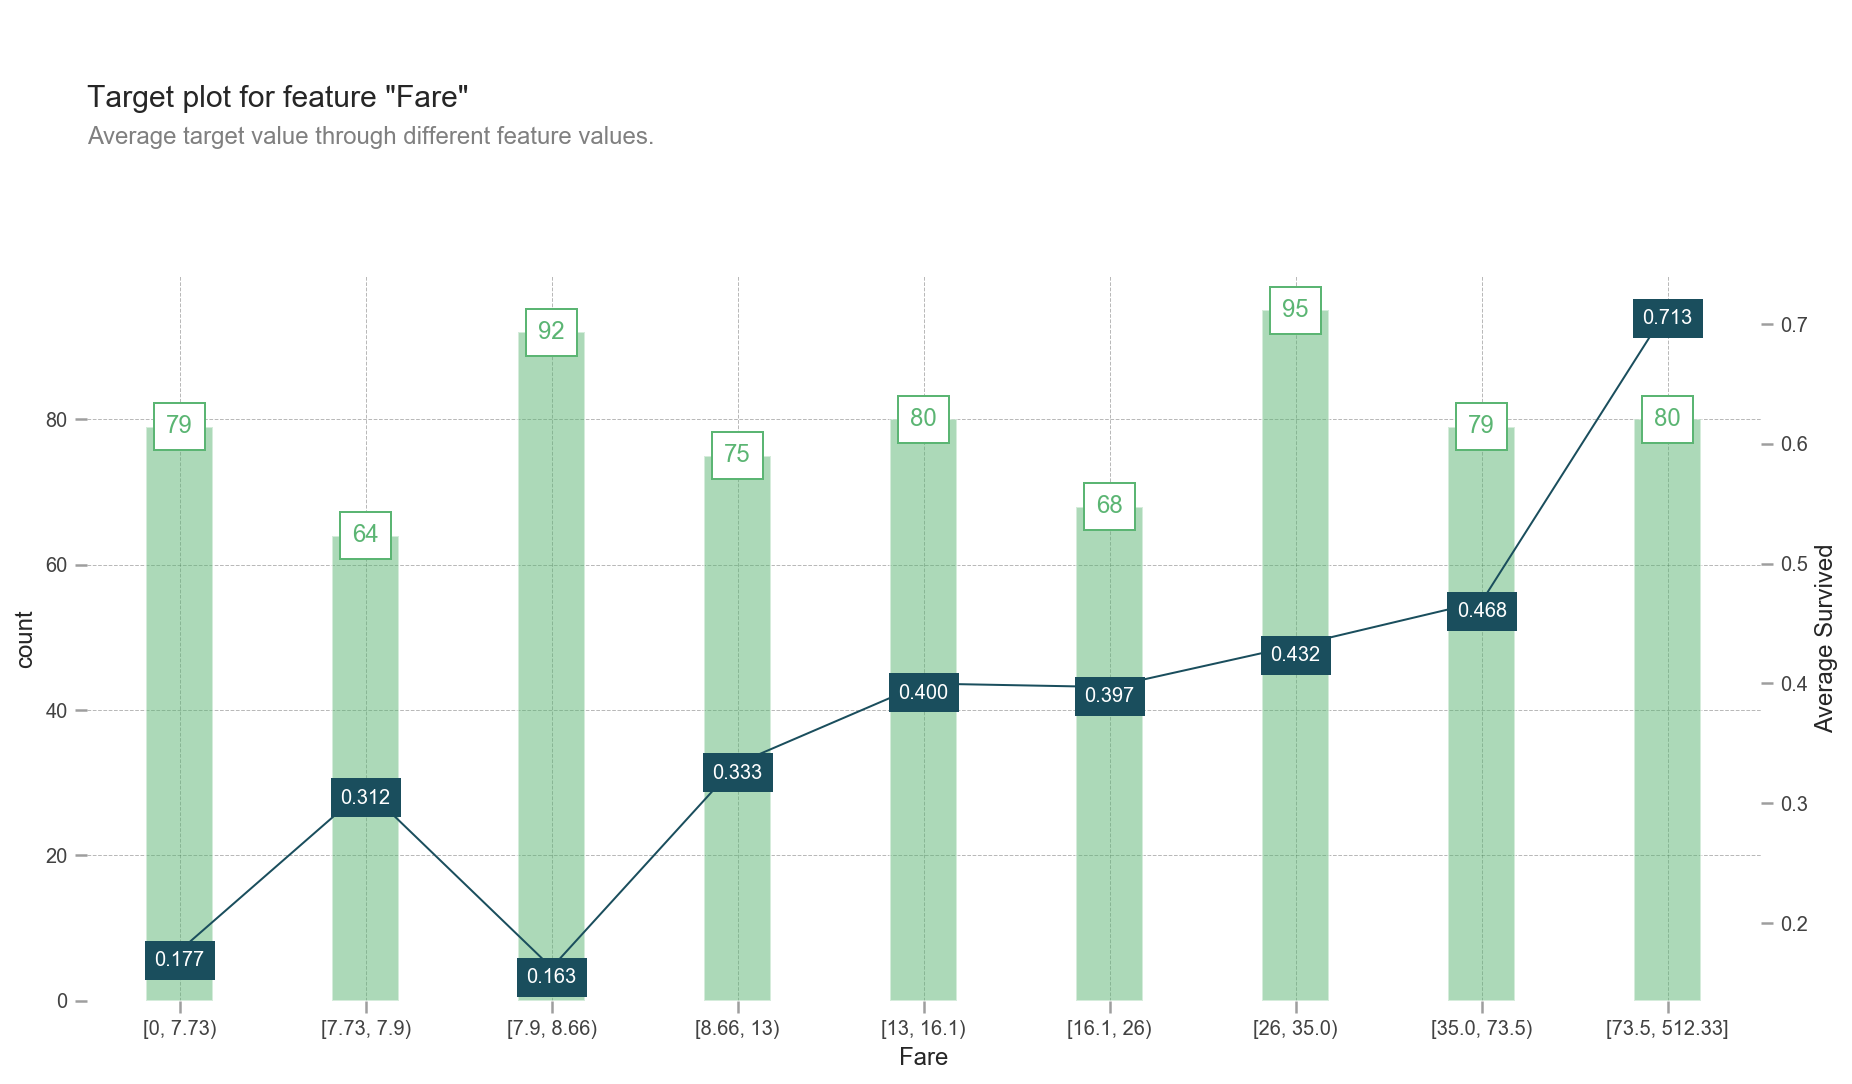

In [200]:
info_plots.target_plot(X_trn.assign(Survived=trn.Survived), 
                       'Fare', 'Fare', 'Survived');

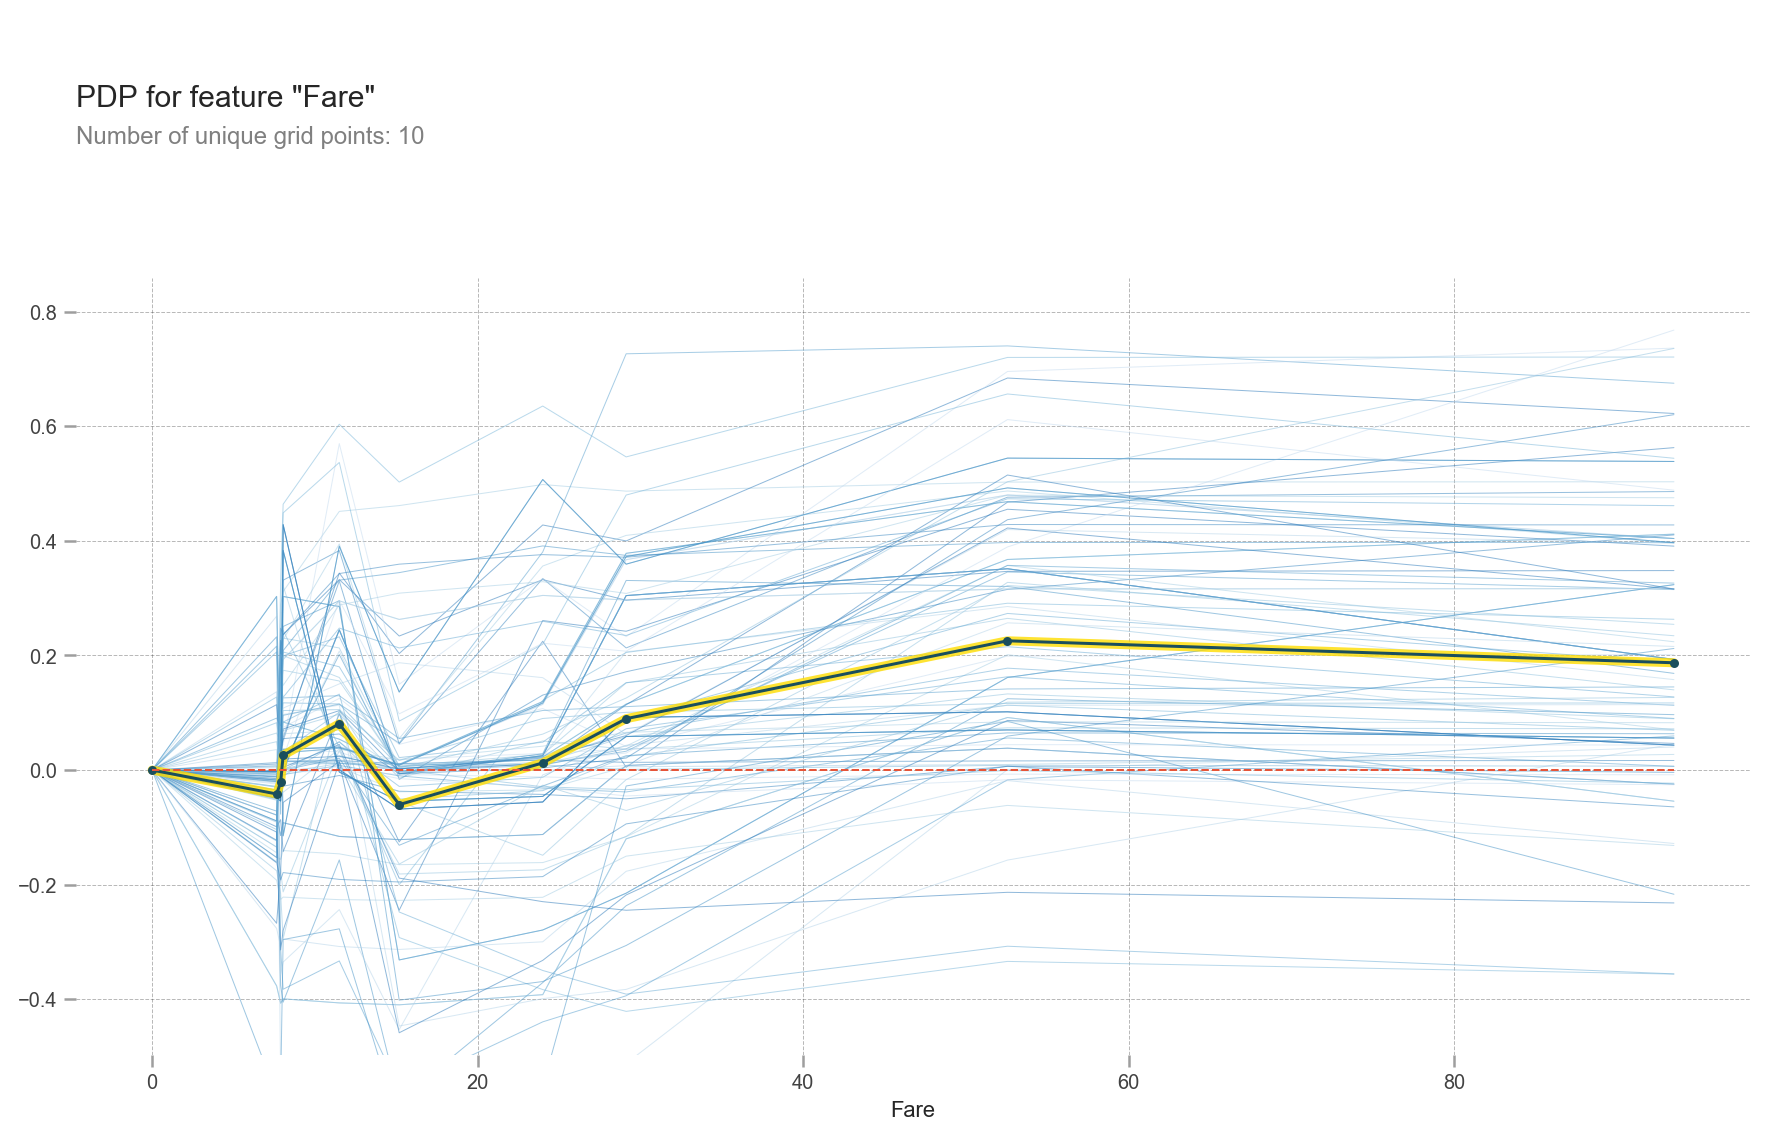

In [213]:
pdp_fare = pdp.pdp_isolate(model, X_trn[X_trn.Fare < 100], X_trn.columns, 'Fare')
pdp.pdp_plot(pdp_fare, 'Fare', plot_lines=True, frac_to_plot=100);

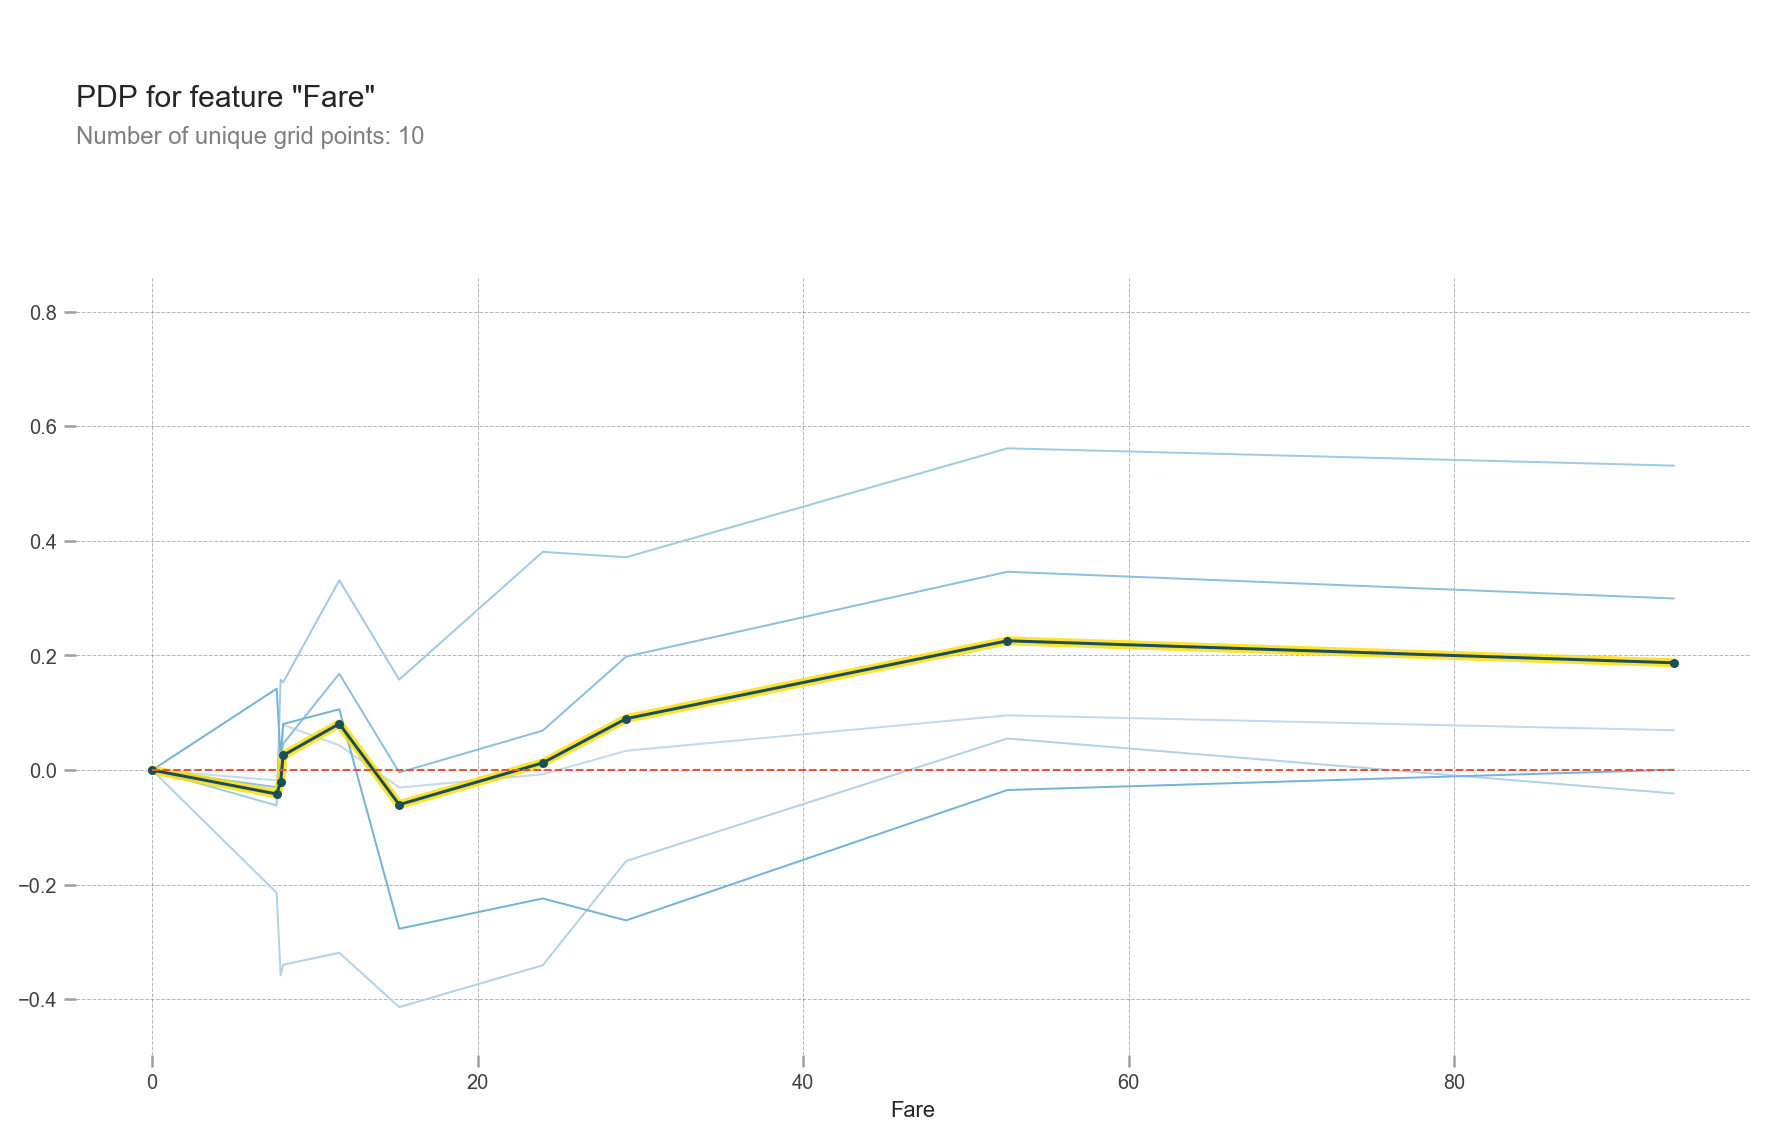

In [212]:
pdp_fare = pdp.pdp_isolate(model, X_trn[X_trn.Fare < 100], X_trn.columns, 'Fare')
pdp.pdp_plot(pdp_fare, 'Fare', plot_lines=True, frac_to_plot=100, cluster=True, n_cluster_centers=5);

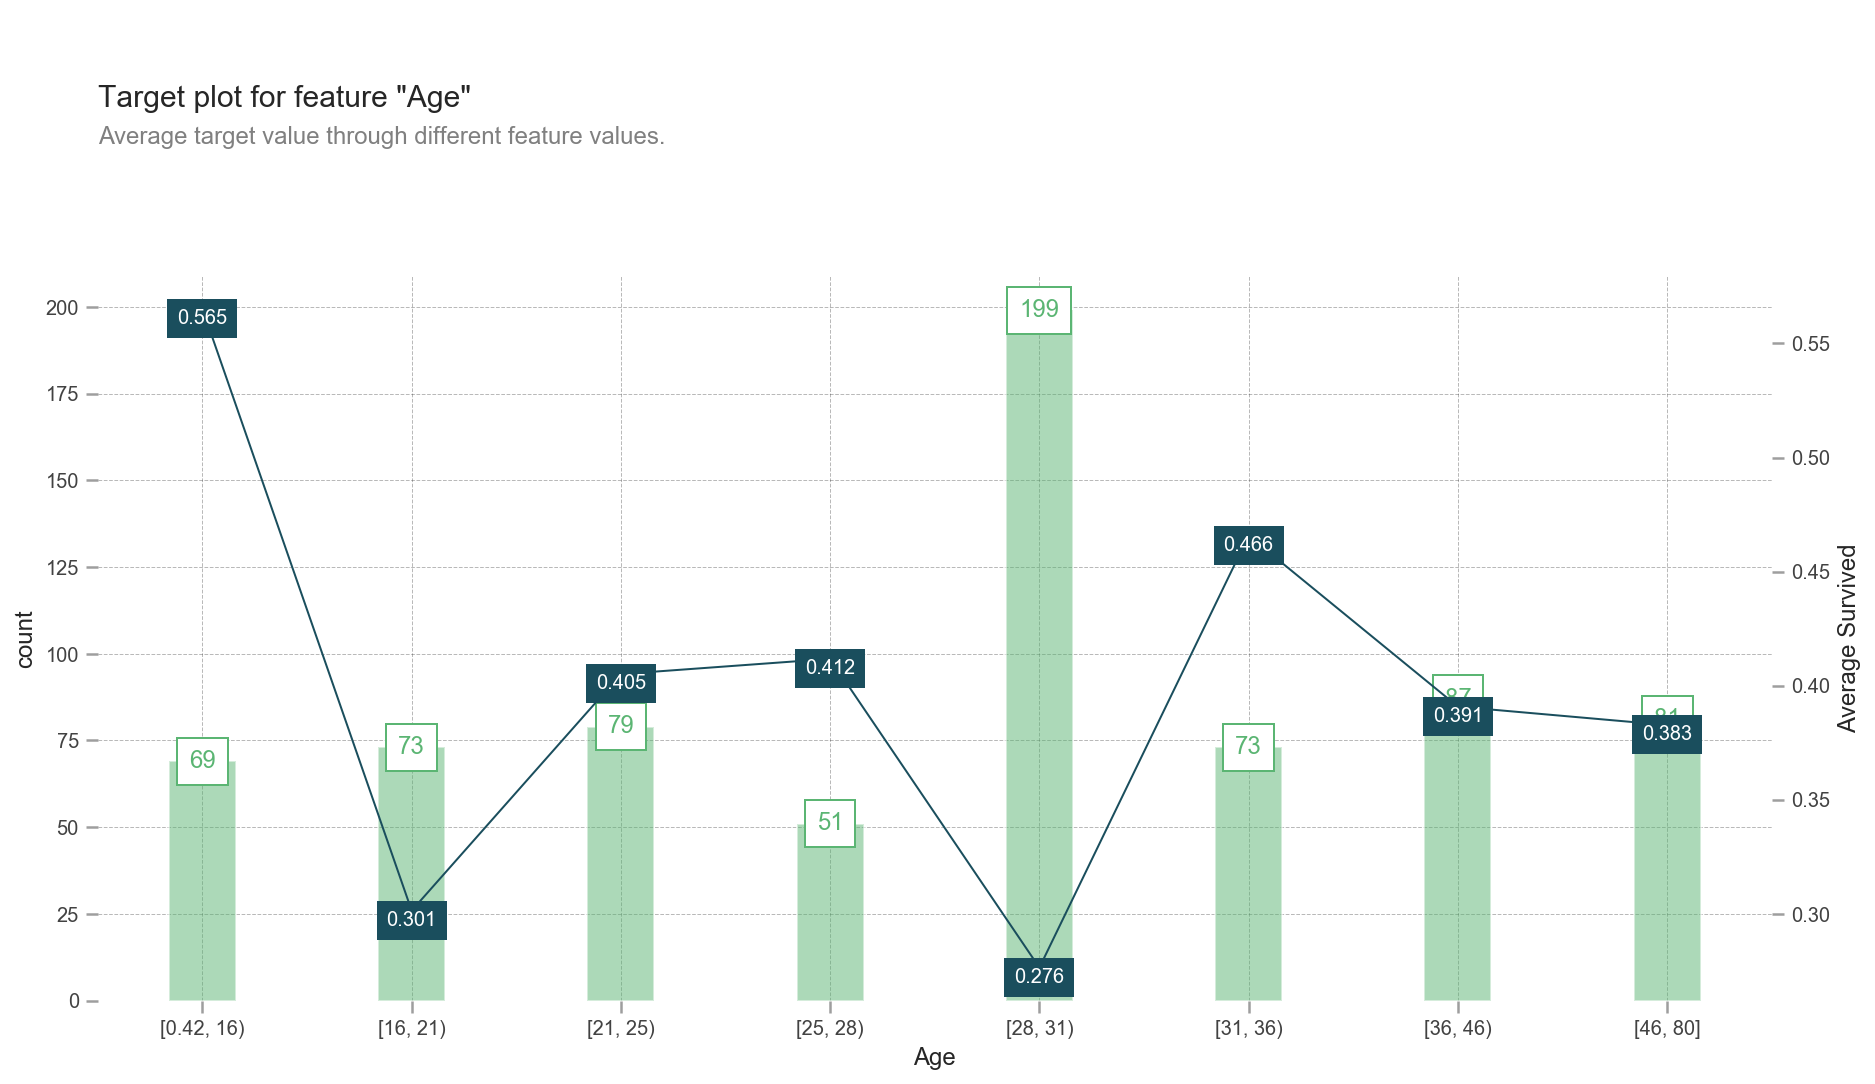

In [201]:
info_plots.target_plot(X_trn.assign(Survived=trn.Survived), 
                       'Age', 'Age', 'Survived');

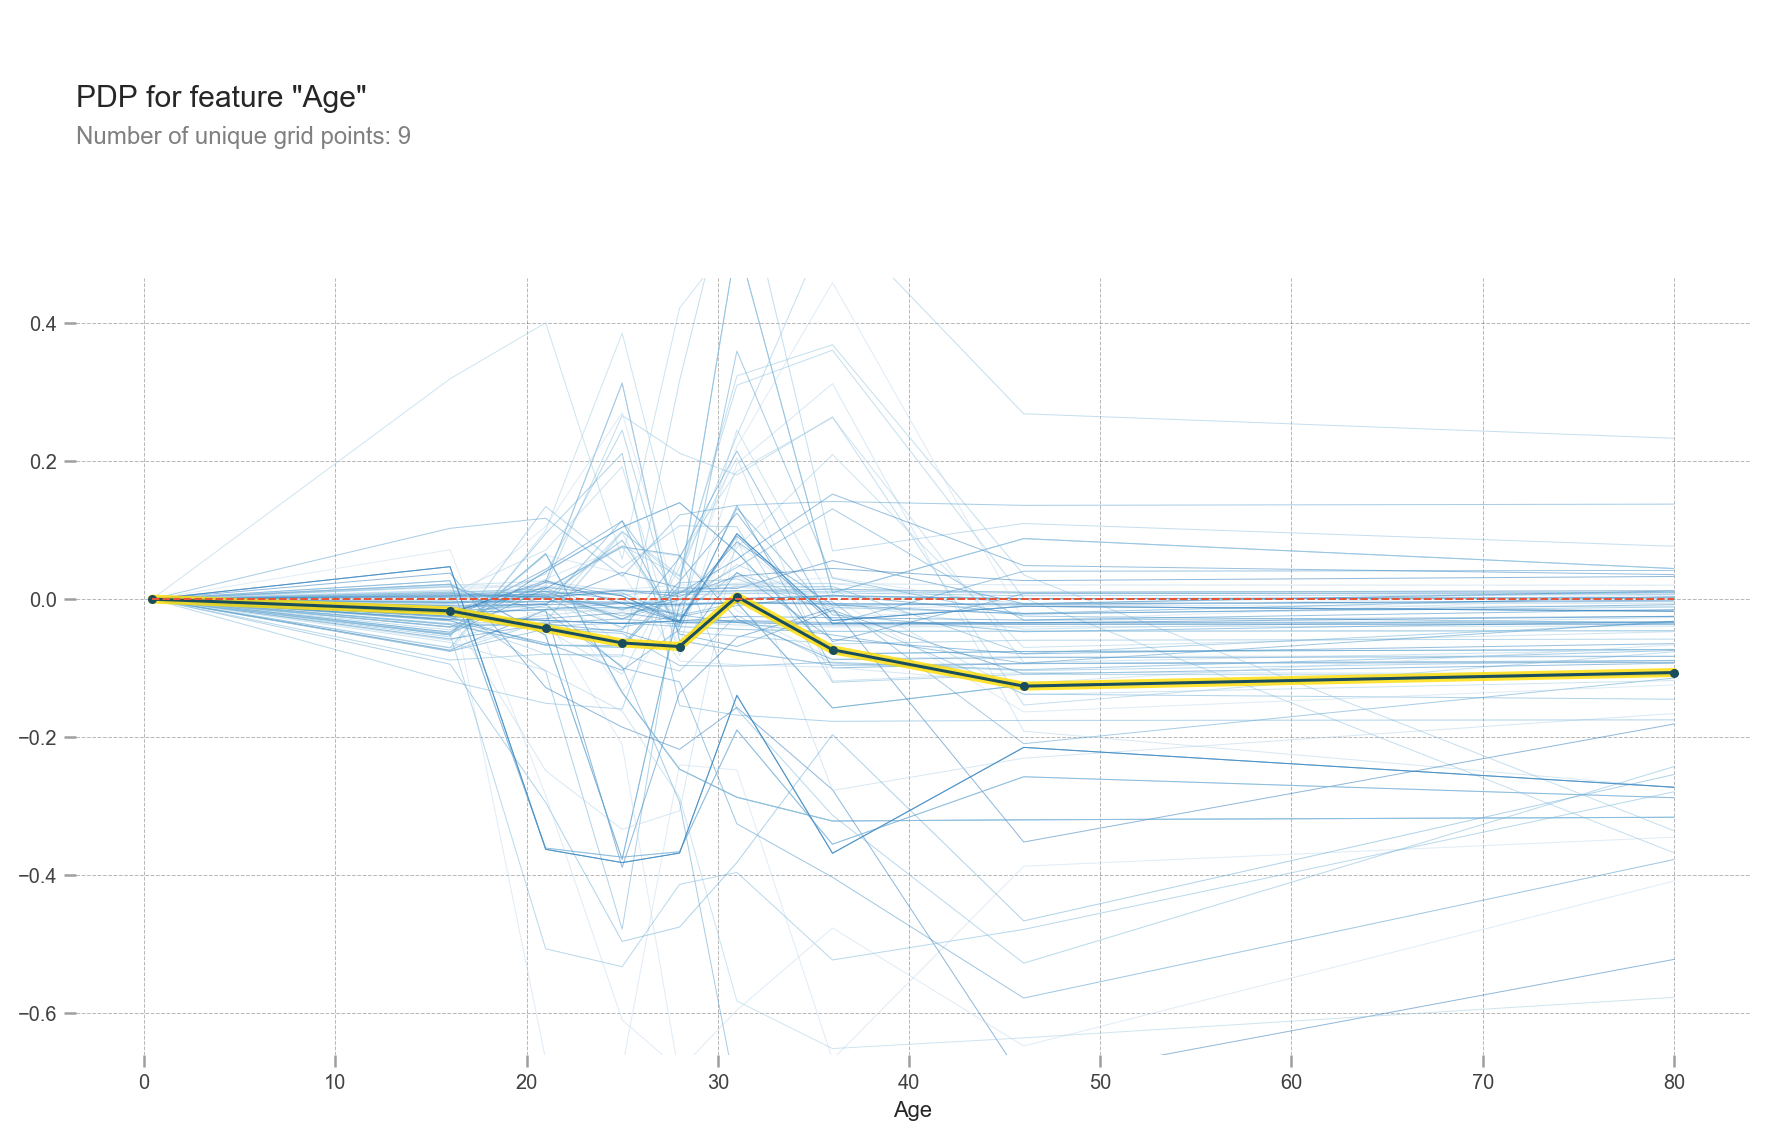

In [211]:
pdp_age = pdp.pdp_isolate(model, X_trn, X_trn.columns, 'Age')
pdp.pdp_plot(pdp_age, 'Age', plot_lines=True, frac_to_plot=100);

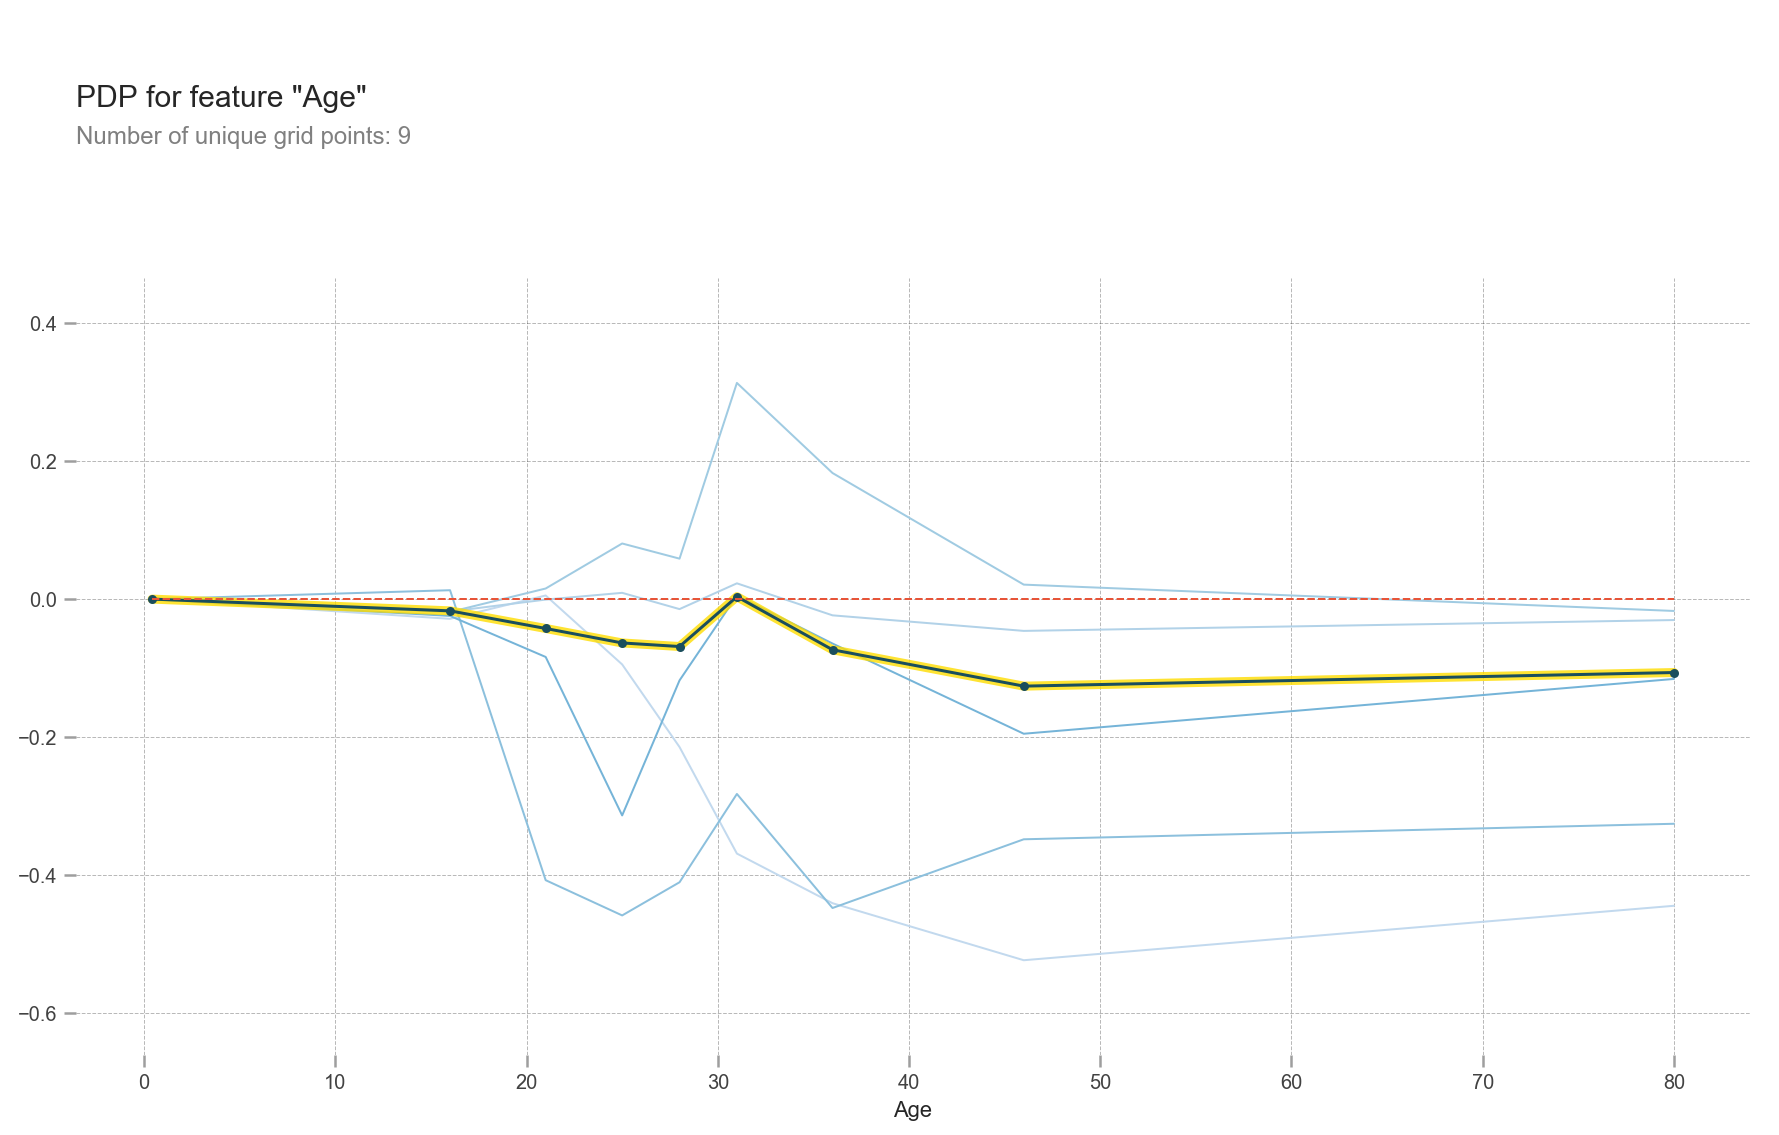

In [210]:
pdp_age = pdp.pdp_isolate(model, X_trn, X_trn.columns, 'Age')
pdp.pdp_plot(pdp_age, 'Age', plot_lines=True, frac_to_plot=100, cluster=True, n_cluster_centers=5);

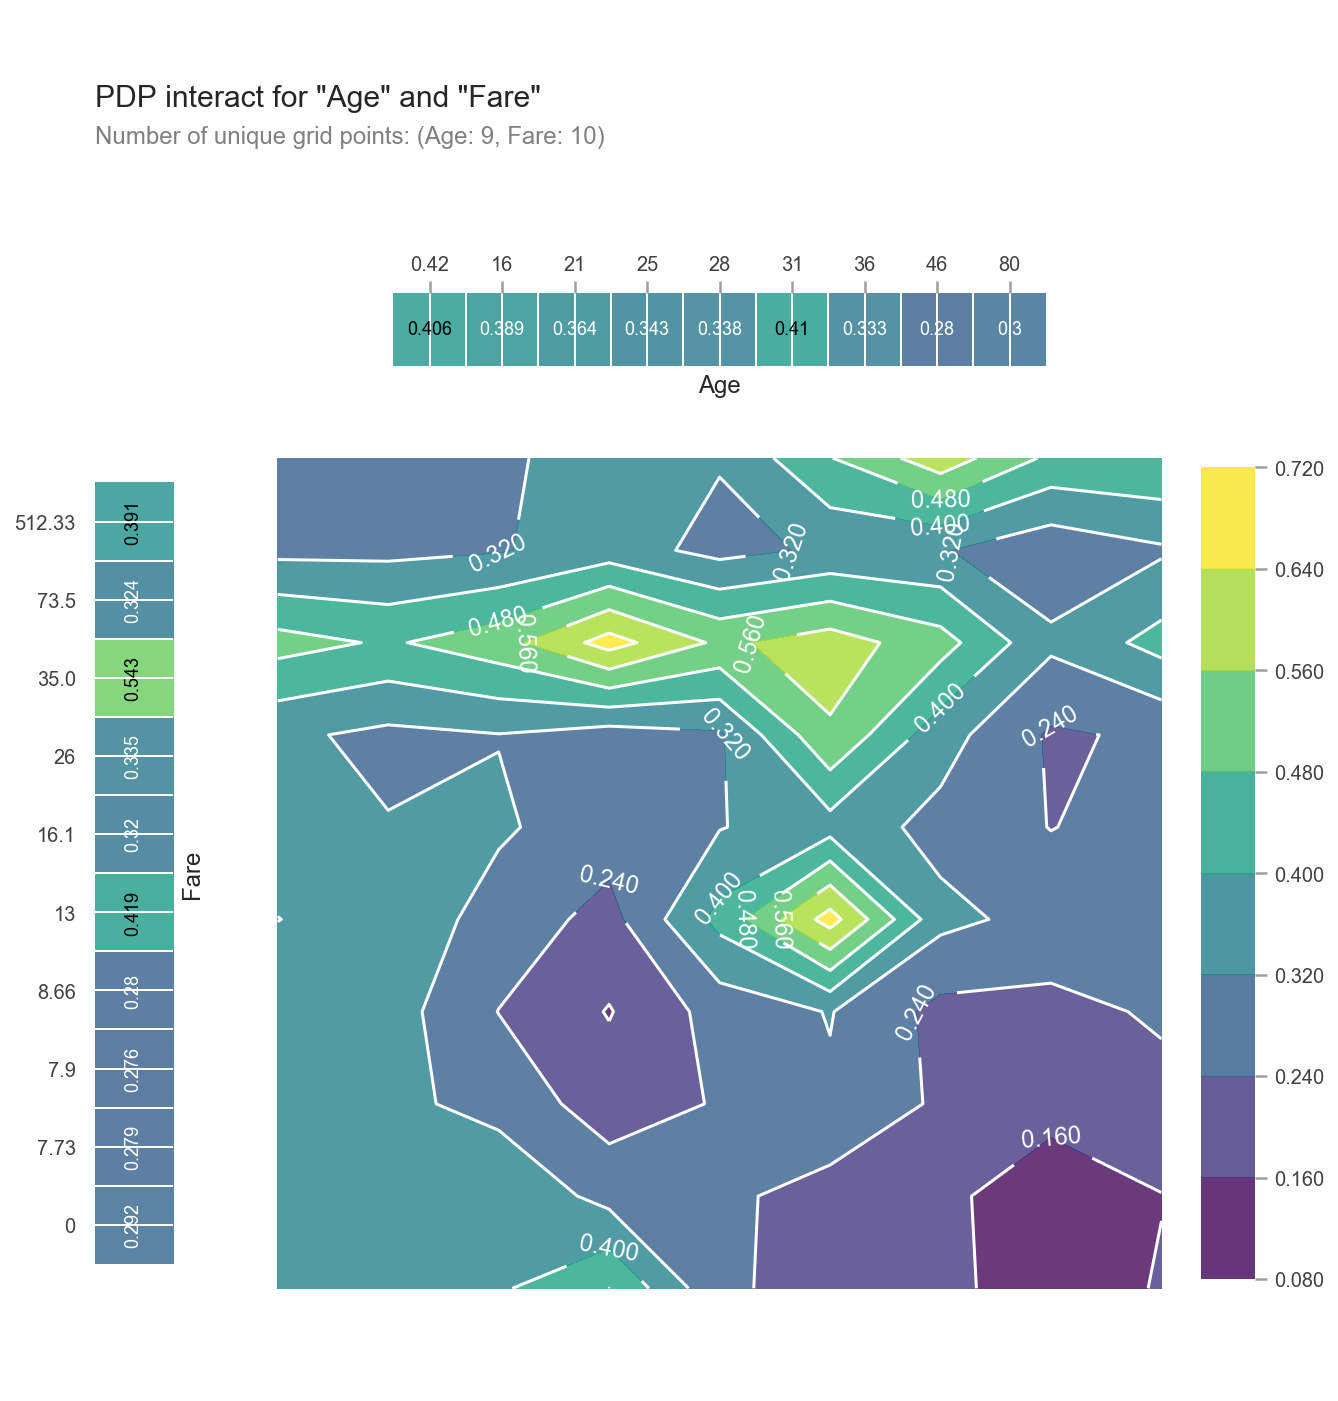

In [219]:
pdp_age_fare = pdp.pdp_interact(model, X_trn, X_trn.columns, ['Age', 'Fare'])
pdp.pdp_interact_plot(pdp_age_fare, ['Age', 'Fare'], plot_pdp=True);

## Tree interpreter

In [232]:
rf = RandomForestClassifier(n_estimators=100, max_depth=15)
rf = rf.fit(X_trn, trn.Survived)

In [222]:
from treeinterpreter import treeinterpreter as ti

In [258]:
sample = X_val.sample()
sample

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,AgeMissing,FamilySize,Title
889,1,1,26.0,0,0,30.0,0,False,1,3


In [260]:
val.loc[[889]]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0,C148,C


In [261]:
preds, bias, contributions = ti.predict(rf, sample)

In [267]:
# Veamos las contribuciones con el nombre de las variables
tt = pd.DataFrame(contributions[0].T, columns=sample.columns).T.sort_values(0)
tt.style.background_gradient(cmap='YlOrRd')

,0,1
Age,-0.230738,0.230738
Fare,-0.116435,0.116435
Pclass,-0.10489,0.10489
Embarked,-0.0074191,0.0074191
FamilySize,-0.00651702,0.00651702
Parch,-0.00617247,0.00617247
AgeMissing,0.00279505,-0.00279505
SibSp,0.00801319,-0.00801319
Title,0.0914461,-0.0914461
Sex,0.157445,-0.157445
